<a href="https://colab.research.google.com/github/hun9008/ML_TeamProject_24SS/blob/main/VGG16_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/ML_TeamProject/

/content/drive/MyDrive/ML_TeamProject


In [3]:
ls

data/             images_png/                                        VGG.ipynb
images_gray_jpg/  preprocessed_images_40/                            무_train_labeled_2000/
images_gray_png/  PreTest.ipynb
images_jpg/       vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
import tensorflow as tf
import os
import pickle
import optuna
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [5]:
image_jpg_path = "/content/drive/My Drive/ML_TeamProject/images_jpg"
image_png_path = "/content/drive/My Drive/ML_TeamProject/images_png"
image_gray_jpg_path = "/content/drive/My Drive/ML_TeamProject/images_gray_jpg"
image_gray_png_path = "/content/drive/My Drive/ML_TeamProject/images_gray_png"

In [7]:
os.chdir("/content/drive/My Drive/ML_TeamProject/images_png")
!ls

images_png.zip	incipient  mature  no  overripe


In [8]:
# !unzip -q images_gray_jpg.zip

In [9]:
!ls

images_png.zip	incipient  mature  no  overripe


In [10]:
image_path = image_png_path

In [ ]:
# os.rename('overripe_train_labeled_2000','overripe')
# os.rename('no_train_labeled_2000','no')
# os.rename('mature_train_labeled_2000','mature')
# os.rename('incipient_train_labeled_2000','incipient')

In [11]:
!ls

images_png.zip	incipient  mature  no  overripe


Pickle load to variable

In [12]:
os.chdir(os.path.join(image_path, 'overripe'))
with open('zero_centering.pkl', 'rb') as f:
     overripe = pickle.load(f)
     print('overripe : ', len(overripe))
os.chdir(os.path.join(image_path, 'no'))
with open('zero_centering.pkl', 'rb') as f:
     no = pickle.load(f)
     print('no : ', len(no))

os.chdir(os.path.join(image_path, 'mature'))
with open('zero_centering.pkl', 'rb') as f:
     mature = pickle.load(f)
     print('mature : ', len(mature))

os.chdir(os.path.join(image_path, 'incipient'))
with open('zero_centering.pkl', 'rb') as f:
     incipient = pickle.load(f)
     print('incipient : ', len(incipient))

overripe :  2000
no :  2000
mature :  2000
incipient :  2000


Dictionary to numpy array

In [13]:
# overripe의 모든 사진에 대해 반복
overripe_data_list = []

for filename, data in overripe.items():
    zero_centering_value = data.get('zero_centering')
    overripe_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
overripe_data = np.array(overripe_data_list)

# 확인을 위해 배열의 크기 출력
print("overripe_data shape:", overripe_data.shape)
no_data_list = []

for filename, data in no.items():
    zero_centering_value = data.get('zero_centering')
    no_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
no_data = np.array(no_data_list)

# 확인을 위해 배열의 크기 출력
print("no_data shape:", no_data.shape)

mature_data_list = []

for filename, data in mature.items():
    zero_centering_value = data.get('zero_centering')
    mature_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
mature_data = np.array(mature_data_list)

# 확인을 위해 배열의 크기 출력
print("mature_data shape:", mature_data.shape)

incipient_data_list = []

for filename, data in incipient.items():
    zero_centering_value = data.get('zero_centering')
    incipient_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
incipient_data = np.array(incipient_data_list)

# 확인을 위해 배열의 크기 출력
print("incipient_data shape:", incipient_data.shape)

overripe_data shape: (2000, 224, 224, 3)
no_data shape: (2000, 224, 224, 3)
mature_data shape: (2000, 224, 224, 3)
incipient_data shape: (2000, 224, 224, 3)


Train Val Test split (0.75:0.15:0.15)

In [14]:
# 데이터를 train/validation/test로 나누기
X = np.concatenate((overripe_data, no_data, mature_data, incipient_data), axis=0)
y = np.concatenate((np.zeros(overripe_data.shape[0]), np.ones(no_data.shape[0]),
                    2*np.ones(mature_data.shape[0]), 3*np.ones(incipient_data.shape[0])))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5600, 224, 224, 3)
(1200, 224, 224, 3)
(1200, 224, 224, 3)


y one-hot

In [15]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

# Hyperparameter tuning

In [16]:
# memory reduce
del overripe, no, mature, incipient
del overripe_data, no_data, mature_data, incipient_data
del overripe_data_list, no_data_list, mature_data_list, incipient_data_list
del X, y
del y_train, y_temp, y_val, y_test

In [17]:

def objective(trial, X_train, y_train, X_val, y_val):
    # Define parameters to be tuned
    # 여기서 lr, epochs, batch_size가 하이퍼파라미터튜닝 대상입니다.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate
    epochs = 10
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Batch size

    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    model = Sequential([
        base_model,
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(4, activation='softmax')  # Assuming 4 classes for classification
    ])

    # Compile model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    return val_loss


In [18]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train_one_hot, X_val, y_val_one_hot), n_trials=5)

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-05-09 14:22:15,931] A new study created in memory with name: no-name-ead5e2da-894b-4a2f-acb9-ad57be670ccf
<ipython-input-17-b90f7572b410>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Learning rate


Epoch 1/10
350/350 [==============================] - 12s 26ms/step - loss: 1.3506 - accuracy: 0.5505 - val_loss: 0.8426 - val_accuracy: 0.5508
Epoch 2/10
350/350 [==============================] - 7s 21ms/step - loss: 0.7393 - accuracy: 0.6441 - val_loss: 0.7984 - val_accuracy: 0.6025
Epoch 3/10
350/350 [==============================] - 7s 21ms/step - loss: 0.6581 - accuracy: 0.6955 - val_loss: 0.7525 - val_accuracy: 0.6325
Epoch 4/10
350/350 [==============================] - 7s 21ms/step - loss: 0.5707 - accuracy: 0.7420 - val_loss: 0.7567 - val_accuracy: 0.6117
Epoch 5/10
350/350 [==============================] - 7s 21ms/step - loss: 0.5277 - accuracy: 0.7616 - val_loss: 0.7609 - val_accuracy: 0.6767
Epoch 6/10
350/350 [==============================] - 7s 21ms/step - loss: 0.4230 - accuracy: 0.8238 - val_loss: 0.7868 - val_accuracy: 0.6625
Epoch 7/10
350/350 [==============================] - 7s 21ms/step - loss: 0.3495 - accuracy: 0.8646 - val_loss: 0.8633 - val_accuracy: 0.659

[I 2024-05-09 14:23:41,022] Trial 0 finished with value: 1.1013264656066895 and parameters: {'lr': 1.983695321134833e-05, 'batch_size': 16}. Best is trial 0 with value: 1.1013264656066895.


Epoch 1/10
350/350 [==============================] - 11s 26ms/step - loss: 1.3086 - accuracy: 0.5550 - val_loss: 0.8601 - val_accuracy: 0.5317
Epoch 2/10
350/350 [==============================] - 7s 21ms/step - loss: 0.7328 - accuracy: 0.6455 - val_loss: 0.8008 - val_accuracy: 0.5950
Epoch 3/10
350/350 [==============================] - 7s 21ms/step - loss: 0.6237 - accuracy: 0.7139 - val_loss: 0.8267 - val_accuracy: 0.6308
Epoch 4/10
350/350 [==============================] - 7s 21ms/step - loss: 0.5562 - accuracy: 0.7538 - val_loss: 0.7644 - val_accuracy: 0.6425
Epoch 5/10
350/350 [==============================] - 7s 21ms/step - loss: 0.5212 - accuracy: 0.7780 - val_loss: 0.8344 - val_accuracy: 0.6458
Epoch 6/10
350/350 [==============================] - 7s 21ms/step - loss: 0.4250 - accuracy: 0.8241 - val_loss: 0.8197 - val_accuracy: 0.6483
Epoch 7/10
350/350 [==============================] - 7s 21ms/step - loss: 0.3555 - accuracy: 0.8529 - val_loss: 0.9485 - val_accuracy: 0.651

[I 2024-05-09 14:25:02,797] Trial 1 finished with value: 1.0756701231002808 and parameters: {'lr': 4.5747263801791895e-05, 'batch_size': 16}. Best is trial 1 with value: 1.0756701231002808.


Epoch 1/10
88/88 [==============================] - 13s 106ms/step - loss: 2.7052 - accuracy: 0.5323 - val_loss: 0.7803 - val_accuracy: 0.6058
Epoch 2/10
88/88 [==============================] - 5s 58ms/step - loss: 0.7108 - accuracy: 0.6696 - val_loss: 0.7707 - val_accuracy: 0.6258
Epoch 3/10
88/88 [==============================] - 5s 58ms/step - loss: 0.5916 - accuracy: 0.7354 - val_loss: 0.7201 - val_accuracy: 0.6533
Epoch 4/10
88/88 [==============================] - 5s 58ms/step - loss: 0.4883 - accuracy: 0.7916 - val_loss: 0.8334 - val_accuracy: 0.6550
Epoch 5/10
88/88 [==============================] - 5s 58ms/step - loss: 0.3887 - accuracy: 0.8416 - val_loss: 0.9495 - val_accuracy: 0.6125
Epoch 6/10
88/88 [==============================] - 5s 58ms/step - loss: 0.3720 - accuracy: 0.8396 - val_loss: 0.9933 - val_accuracy: 0.6417
Epoch 7/10
88/88 [==============================] - 5s 59ms/step - loss: 0.2479 - accuracy: 0.9048 - val_loss: 0.9379 - val_accuracy: 0.6500
Epoch 8/10


[I 2024-05-09 14:26:05,931] Trial 2 finished with value: 1.402034044265747 and parameters: {'lr': 8.473990502287052e-05, 'batch_size': 64}. Best is trial 1 with value: 1.0756701231002808.


Epoch 1/10
350/350 [==============================] - 10s 24ms/step - loss: 1.4459 - accuracy: 0.5354 - val_loss: 0.8690 - val_accuracy: 0.5675
Epoch 2/10
350/350 [==============================] - 7s 21ms/step - loss: 0.7545 - accuracy: 0.6271 - val_loss: 0.7839 - val_accuracy: 0.6167
Epoch 3/10
350/350 [==============================] - 7s 21ms/step - loss: 0.6466 - accuracy: 0.6952 - val_loss: 0.8335 - val_accuracy: 0.6208
Epoch 4/10
350/350 [==============================] - 7s 21ms/step - loss: 0.5525 - accuracy: 0.7564 - val_loss: 0.8808 - val_accuracy: 0.5950
Epoch 5/10
350/350 [==============================] - 7s 21ms/step - loss: 0.5117 - accuracy: 0.7784 - val_loss: 0.7478 - val_accuracy: 0.6558
Epoch 6/10
350/350 [==============================] - 7s 21ms/step - loss: 0.4420 - accuracy: 0.8100 - val_loss: 0.8556 - val_accuracy: 0.6433
Epoch 7/10
350/350 [==============================] - 7s 20ms/step - loss: 0.3339 - accuracy: 0.8687 - val_loss: 1.1943 - val_accuracy: 0.615

[I 2024-05-09 14:27:25,511] Trial 3 finished with value: 1.1750277280807495 and parameters: {'lr': 0.0008015993811729398, 'batch_size': 16}. Best is trial 1 with value: 1.0756701231002808.


Epoch 1/10
175/175 [==============================] - 8s 40ms/step - loss: 1.9418 - accuracy: 0.5521 - val_loss: 0.8044 - val_accuracy: 0.5833
Epoch 2/10
175/175 [==============================] - 6s 33ms/step - loss: 0.7282 - accuracy: 0.6568 - val_loss: 0.7432 - val_accuracy: 0.6367
Epoch 3/10
175/175 [==============================] - 6s 33ms/step - loss: 0.5952 - accuracy: 0.7302 - val_loss: 0.7524 - val_accuracy: 0.6475
Epoch 4/10
175/175 [==============================] - 6s 33ms/step - loss: 0.5427 - accuracy: 0.7670 - val_loss: 0.7375 - val_accuracy: 0.6725
Epoch 5/10
175/175 [==============================] - 6s 33ms/step - loss: 0.4002 - accuracy: 0.8300 - val_loss: 0.7861 - val_accuracy: 0.6650
Epoch 6/10
175/175 [==============================] - 6s 33ms/step - loss: 0.3459 - accuracy: 0.8634 - val_loss: 1.0440 - val_accuracy: 0.6183
Epoch 7/10
175/175 [==============================] - 6s 33ms/step - loss: 0.2962 - accuracy: 0.8814 - val_loss: 0.9742 - val_accuracy: 0.6617

[I 2024-05-09 14:28:32,449] Trial 4 finished with value: 1.3251692056655884 and parameters: {'lr': 1.0971489140922831e-05, 'batch_size': 32}. Best is trial 1 with value: 1.0756701231002808.


Best parameters: {'lr': 4.5747263801791895e-05, 'batch_size': 16}


Training & Test

In [19]:
print(study.best_params['lr'])
print(study.best_params['batch_size'])


4.5747263801791895e-05
16


In [20]:
def train_vgg16_model():
  # Load pre-trained VGG16 model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the base model layers
  for layer in base_model.layers:
      layer.trainable = False

  # Add custom top layers for classification
  model = Sequential([
      base_model,
      Flatten(),
      Dense(4096, activation='relu'),
      Dense(4096, activation='relu'),
      Dense(4, activation='softmax')
  ])

  # Compile model
  # optimizer = Adam(lr=5.520238899015578e-05)
  optimizer = Adam(lr=study.best_params['lr'])
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Fine-tuning: Unfreeze some layers and train the entire model with new data
  for layer in model.layers:
      if 'block5' in layer.name:  # Unfreeze layers starting from 'block5'
          layer.trainable = True

  # Define early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  # Train the model with early stopping
  history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=study.best_params['batch_size'], epochs=50, callbacks=[early_stopping])
  # history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50, callbacks=[early_stopping])
  # history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50)

  # Plot training history
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()

  # Evaluate the model
  model.summary()
  test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
  print('Test accuracy:', test_acc)

# JPG

Epoch 1/50
350/350 [==============================] - 10s 26ms/step - loss: 1.5059 - accuracy: 0.5362 - val_loss: 0.8181 - val_accuracy: 0.5908
Epoch 2/50
350/350 [==============================] - 7s 21ms/step - loss: 0.7284 - accuracy: 0.6557 - val_loss: 1.0342 - val_accuracy: 0.5142
Epoch 3/50
350/350 [==============================] - 8s 22ms/step - loss: 0.6627 - accuracy: 0.6834 - val_loss: 0.7870 - val_accuracy: 0.6158
Epoch 4/50
350/350 [==============================] - 7s 21ms/step - loss: 0.5683 - accuracy: 0.7418 - val_loss: 0.7330 - val_accuracy: 0.6633
Epoch 5/50
350/350 [==============================] - 7s 21ms/step - loss: 0.5014 - accuracy: 0.7880 - val_loss: 0.8195 - val_accuracy: 0.6483
Epoch 6/50
350/350 [==============================] - 7s 21ms/step - loss: 0.4390 - accuracy: 0.8134 - val_loss: 0.8351 - val_accuracy: 0.6625
Epoch 7/50
350/350 [==============================] - 8s 22ms/step - loss: 0.3568 - accuracy: 0.8532 - val_loss: 0.9598 - val_accuracy: 0.640

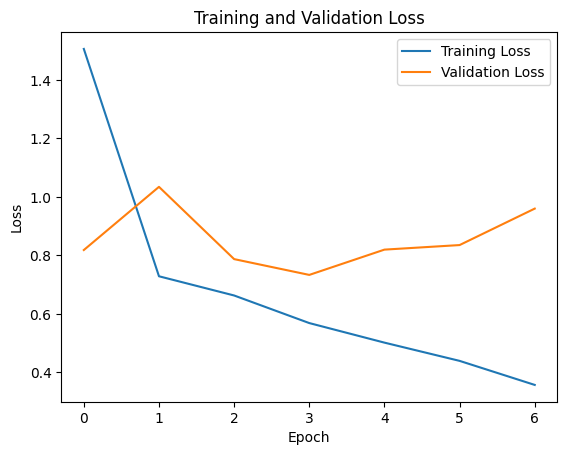

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_16 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_17 (Dense)            (None, 4)                 16388     
                                                                 
Total params: 134276932 (512.23 MB)
Trainable params: 119562244 (456.09 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
38

In [18]:
train_vgg16_model()

# PNG

Epoch 1/50
350/350 [==============================] - 10s 26ms/step - loss: 1.3144 - accuracy: 0.5412 - val_loss: 0.7908 - val_accuracy: 0.5817
Epoch 2/50
350/350 [==============================] - 7s 21ms/step - loss: 0.7577 - accuracy: 0.6325 - val_loss: 0.8625 - val_accuracy: 0.6142
Epoch 3/50
350/350 [==============================] - 7s 21ms/step - loss: 0.6429 - accuracy: 0.7077 - val_loss: 0.7800 - val_accuracy: 0.6350
Epoch 4/50
350/350 [==============================] - 8s 22ms/step - loss: 0.5467 - accuracy: 0.7557 - val_loss: 0.7986 - val_accuracy: 0.6292
Epoch 5/50
350/350 [==============================] - 8s 22ms/step - loss: 0.4818 - accuracy: 0.7984 - val_loss: 0.7796 - val_accuracy: 0.6608
Epoch 6/50
350/350 [==============================] - 8s 21ms/step - loss: 0.3994 - accuracy: 0.8434 - val_loss: 0.9117 - val_accuracy: 0.6642
Epoch 7/50
350/350 [==============================] - 7s 21ms/step - loss: 0.3490 - accuracy: 0.8645 - val_loss: 0.8881 - val_accuracy: 0.670

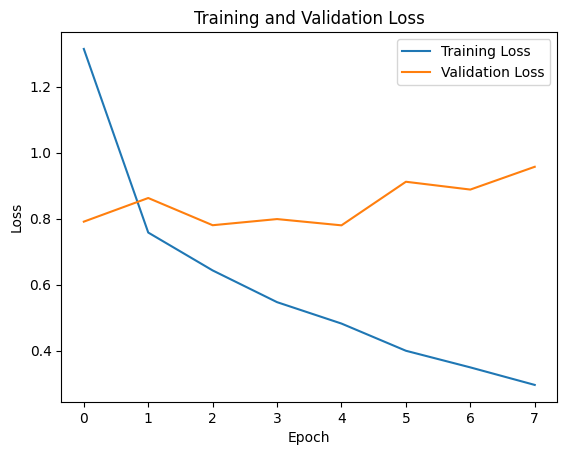

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_16 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_17 (Dense)            (None, 4)                 16388     
                                                                 
Total params: 134276932 (512.23 MB)
Trainable params: 119562244 (456.09 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
38

In [21]:
train_vgg16_model()

# Gray JPG

Epoch 1/50
350/350 [==============================] - 13s 27ms/step - loss: 1.4476 - accuracy: 0.5337 - val_loss: 0.8039 - val_accuracy: 0.5983
Epoch 2/50
350/350 [==============================] - 8s 22ms/step - loss: 0.7467 - accuracy: 0.6464 - val_loss: 0.7575 - val_accuracy: 0.6258
Epoch 3/50
350/350 [==============================] - 7s 21ms/step - loss: 0.6370 - accuracy: 0.7048 - val_loss: 0.8170 - val_accuracy: 0.6250
Epoch 4/50
350/350 [==============================] - 7s 21ms/step - loss: 0.5544 - accuracy: 0.7563 - val_loss: 0.7567 - val_accuracy: 0.6683
Epoch 5/50
350/350 [==============================] - 7s 21ms/step - loss: 0.4992 - accuracy: 0.7911 - val_loss: 0.8078 - val_accuracy: 0.6542
Epoch 6/50
350/350 [==============================] - 7s 21ms/step - loss: 0.4398 - accuracy: 0.8184 - val_loss: 0.8200 - val_accuracy: 0.6625
Epoch 7/50
350/350 [==============================] - 8s 22ms/step - loss: 0.3577 - accuracy: 0.8593 - val_loss: 0.8459 - val_accuracy: 0.679

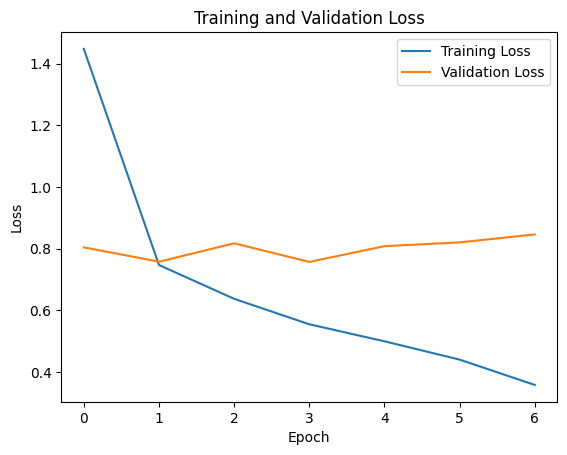

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 4)                 16388     
                                                                 
Total params: 134276932 (512.23 MB)
Trainable params: 119562244 (456.09 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
38/3

In [14]:
train_vgg16_model()

# Gray PNG

Epoch 1/50
350/350 [==============================] - 13s 27ms/step - loss: 1.3113 - accuracy: 0.5441 - val_loss: 0.8340 - val_accuracy: 0.5725
Epoch 2/50
350/350 [==============================] - 7s 21ms/step - loss: 0.7291 - accuracy: 0.6480 - val_loss: 0.8635 - val_accuracy: 0.5967
Epoch 3/50
350/350 [==============================] - 7s 21ms/step - loss: 0.6501 - accuracy: 0.7061 - val_loss: 0.7651 - val_accuracy: 0.6467
Epoch 4/50
350/350 [==============================] - 7s 21ms/step - loss: 0.5569 - accuracy: 0.7545 - val_loss: 0.7240 - val_accuracy: 0.6600
Epoch 5/50
350/350 [==============================] - 7s 21ms/step - loss: 0.5153 - accuracy: 0.7761 - val_loss: 0.7838 - val_accuracy: 0.6575
Epoch 6/50
350/350 [==============================] - 7s 21ms/step - loss: 0.4314 - accuracy: 0.8198 - val_loss: 0.8523 - val_accuracy: 0.6483
Epoch 7/50
350/350 [==============================] - 7s 21ms/step - loss: 0.3548 - accuracy: 0.8582 - val_loss: 0.8684 - val_accuracy: 0.663

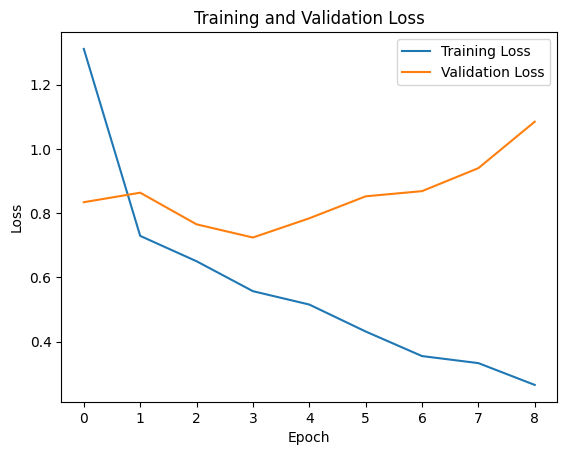

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 4)                 16388     
                                                                 
Total params: 134276932 (512.23 MB)
Trainable params: 119562244 (456.09 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
38/3

In [16]:
train_vgg16_model()

In [28]:
images_jpg_score = 0.6641666889190674

In [29]:
images_png_score = 0.6616666913032532

In [ ]:
images_gray_jpg_score = 0.6766666769981384

In [ ]:
images_gray_png_score = 0.6666666865348816